In [13]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

import io
import roma
import kornia
import evo
import evo.main_ape as main_ape
import evo.main_rpe as main_rpe
import utils.colmap as colmap_utils


from tqdm import tqdm
from evo.core.metrics import PoseRelation, Unit
from evo.core.trajectory import PoseTrajectory3D
from evo.core import lie_algebra
from evo.tools.plot import PlotMode
from copy import deepcopy
from scipy.spatial.transform import Rotation
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio, load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.dependency.track_predict import predict_tracks
from vggt.dependency.np_to_pycolmap import batch_np_matrix_to_pycolmap, batch_np_matrix_to_pycolmap_wo_track

from utils.umeyama import umeyama
from utils.metric_torch import camera_to_rel_deg, calculate_auc_np

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def run_VGGT(model, images, dtype, resolution=518, track_feat=False):
    # images: [B, 3, H, W]

    assert len(images.shape) == 4
    assert images.shape[1] == 3

    device = next(model.parameters()).device
    images = images.to(device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            valid_layers = model.depth_head.intermediate_layer_idx
            if valid_layers[-1] != model.aggregator.aa_block_num - 1:
                valid_layers.append(model.aggregator.aa_block_num - 1)
            aggregated_tokens_list, ps_idx = model.aggregator(images, valid_layers)
            aggregated_tokens_list = [tokens.to(device) if tokens is not None else None for tokens in aggregated_tokens_list]

        # Predict Cameras
        pose_enc = model.camera_head(aggregated_tokens_list)[-1]
        # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])
        # Predict Depth Maps
        depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = depth_map.squeeze(0).cpu().numpy()
        depth_conf = depth_conf.squeeze(0).cpu().numpy()

        track_feature_maps = None if not track_feat else model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)
        
    return extrinsic, intrinsic, depth_map, depth_conf, track_feature_maps

def evaluate_auc(pred_se3, gt_se3, device):

    camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
    camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
    c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred.T)
    camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
    print("    --  Umeyama Scale: ", c)
    print("    --  Umeyama Rotation: \n", R)
    print("    --  Umeyama Translation: \n", t)

    ext_transform = np.eye(4)
    ext_transform[:3, :3] = R
    ext_transform[:3, 3:] = t
    ext_transform = np.linalg.inv(ext_transform)

    gt_aligned = np.zeros((gt_se3.shape[0], 4, 4))
    gt_aligned[:, :3, :3] = gt_se3[:, :3, :3].cpu().numpy()
    gt_aligned[:, :3, 3] = gt_se3[:, 3, :3].cpu().numpy() * c
    gt_aligned[:, 3, 3] = 1.0
    gt_aligned = np.einsum('bmn,bnk->bmk', gt_aligned, ext_transform[None])

    gt_se3_aligned = torch.eye(4, device=device).unsqueeze(0).repeat(len(gt_se3), 1, 1)
    gt_se3_aligned[:, :3, :3] = torch.tensor(gt_aligned[:, :3, :3], device=device)
    gt_se3_aligned[:, 3, :3] = torch.tensor(gt_aligned[:, :3, 3], device=device)

    rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3, gt_se3_aligned, device, 4)
    print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
    print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

    rError = rel_rangle_deg.cpu().numpy()
    tError = rel_tangle_deg.cpu().numpy()

    Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
    print(f"    --  AUC at 30: {Auc_30:.4f}")

    results = {
        'rel_rangle_deg': rel_rangle_deg.mean(),
        'rel_tangle_deg': rel_tangle_deg.mean(),
        'Auc_30': Auc_30,
    }

    return results

def image_pair_candidates(extrinsic, pairing_angle_threshold=30, unique_pairs=False):

    pairs, pairs_cnt = {}, 0

    # assert i_map is None or len(i_map) == len(extrinsics)

    num_images = len(extrinsic)
    
    extrinsic_tensor = torch.from_numpy(extrinsic)

    for i in range(num_images):
        
        rot_mat_i = extrinsic_tensor[i:i+1, :3, :3]
        rot_mats_j = extrinsic_tensor[i+1:, :3, :3]

        rot_mat_ij = torch.matmul(rot_mat_i, torch.linalg.inv(rot_mats_j))
        angle_rad = torch.acos((rot_mat_ij.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1) - 1) / 2)
        angle_deg = angle_rad / np.pi * 180

        i_entry = i
        j_entries = (i + 1 + torch.where(torch.abs(angle_deg) < pairing_angle_threshold)[0]).tolist()

        pairs_cnt += len(j_entries)

        if not i_entry in pairs.keys():
            pairs[i_entry] = []
        pairs[i_entry] = pairs[i_entry] + j_entries

        if not unique_pairs:
            for j_entry in j_entries:
                if not j_entry in pairs.keys():
                    pairs[j_entry] = []
                pairs[j_entry].append(i_entry)

    return pairs, pairs_cnt

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    if torch.is_tensor(img1):
        img1 = img1[0].permute(1, 2, 0).cpu().numpy()
        if img1.max() > 1.0:
            img1 = img1.astype(np.uint8)
        else:
            img1 = (img1 * 255).astype(np.uint8)
    if torch.is_tensor(img2):
        img2 = img2[0].permute(1, 2, 0).cpu().numpy()
        if img2.max() > 1.0:
            img2 = img2.astype(np.uint8)
        else:
            img2 = (img2 * 255).astype(np.uint8)

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [4]:
# Get image paths and preprocess them
data_dir = "../data/MipNeRF360/bonsai"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
images_dir = os.path.join(data_dir, "images")

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

In [5]:
sample_interval = 2
images_gt_updated = {id: images_gt[id] for id in list(images_gt.keys())[::sample_interval]}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]
total_frame_num = len(image_path_list)

vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, vggt_fixed_resolution)

# plot images
# plt.figure(figsize=(16, 10))
# for i, img in enumerate(images):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(img.permute(1, 2, 0).cpu().numpy())
#     plt.title(base_image_path_list[i].split('_Zenmuse')[0])
#     plt.axis('off')

In [6]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
extrinsic, intrinsic, depth_map, depth_conf, track_feats = run_VGGT(model, images, dtype, vggt_fixed_resolution, track_feat=True)
points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)
torch.cuda.empty_cache()

In [7]:
fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

/tmp/ipykernel_23950/4258586071.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)


    --  Umeyama Scale:  0.1288192559990478
    --  Umeyama Rotation: 
 [[ 0.45081263  0.64321758 -0.61890154]
 [-0.24285261  0.75558252  0.60837294]
 [ 0.85894736 -0.12396034  0.49683322]]
    --  Umeyama Translation: 
 [[ 0.03394914]
 [-0.29819329]
 [ 0.46752822]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.58
    --  Pair Trans Error (Deg) of Vanilla:       2.22
    --  AUC at 30: 0.9280


## 1. Calculate Tracking

In [8]:
conf_threshold = 1.5
num_track_pts = 200
mask = depth_conf > conf_threshold

idx = random.randint(0, total_frame_num - 1)
image_masked = images[idx].cpu().numpy().transpose(1, 2, 0) * mask[idx][:, :, None]
image_org = images[idx].cpu().numpy().transpose(1, 2, 0)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_org)
plt.title(f"Original Image of {idx}")
plt.tight_layout()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_masked)
plt.title("Masked Image with Depth Confidence > {}".format(conf_threshold))
# pick up num_track_pts points with highest depth confidence and mark them as red x on the image
# mark_points = np.argsort(depth_conf[idx].flatten())[-num_track_pts:]
# randomly select num_track_pts points with highest depth confidence and mark them as red x on the image
valid_index = np.where(mask[idx].flatten())[0].tolist()
mark_points = random.sample(valid_index, num_track_pts)
for point in mark_points:
    y, x = divmod(point, depth_conf[idx].shape[1])
    plt.scatter(x, y, color='red', s=10, marker='x')

plt.tight_layout()
plt.axis('off')

/tmp/ipykernel_16671/702566580.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(-0.5, 517.5, 349.5, -0.5)

In [28]:
pairs, pairs_cnt = image_pair_candidates(extrinsic, pairing_angle_threshold=30, unique_pairs=True)
print("Total candidate image pairs found: ", pairs_cnt)

indexes_i = list(range(len(image_path_list)-1))  # the last image 
indexes_j = [np.random.choice(pairs[idx_i], min(10, len(pairs[idx_i])), replace=False) for idx_i in indexes_i]
# indexes_i = [np.array([idx_i] * len(indexes_j[idx_i])) for idx_i in indexes_i]
# indexes_i = np.concatenate(indexes_i).tolist()
# indexes_j = np.concatenate(indexes_j).tolist()

conf_threshold = 1.5
score_threshold = conf_threshold * 0.05
max_num_track_pts = 4096
mask = depth_conf > conf_threshold

batch_size = 100
corr_points_i_list = []
corr_points_j_list = []
image_names_i = []
image_names_j = []
frame_indexes_i = []
frame_indexes_j = []
scores_list = []

for i in tqdm(range(0, len(indexes_i)), desc="Tracking image pairs"):
    indexes_i_batch = indexes_i[i]
    indexes_j_batch = indexes_j[i]
    indexes = [indexes_i_batch] + indexes_j_batch.tolist()

    # Randomly choose query points from the masked depth confidence map?
    query_points_list, valid_index = [], np.where(mask[i].flatten())[0].tolist()
    num_track_pts = min(max_num_track_pts, len(valid_index))
    valid_points = np.random.choice(valid_index, num_track_pts, replace=True).tolist()
    for point in valid_points:
        y, x = divmod(point, depth_conf[i].shape[1])
        query_points_list.append([x, y])
    query_points = torch.FloatTensor(query_points_list).to(device)

    assert query_points[:, 1].max() < depth_conf[i].shape[0] and query_points[:, 0].max() < depth_conf[i].shape[1], \
        f"Query points {query_points[:, 1].max()} and {query_points[:, 0].max()} are out of bounds for depth map shape {depth_conf[i].shape}"

    with torch.no_grad():
        track_list, vis_score, conf_score = model.track_head.tracker(query_points=query_points[None], fmaps=track_feats[:, indexes], iters=model.track_head.iters)
        track_scores = conf_score * vis_score
        track_scores[(conf_score < score_threshold) | (vis_score < score_threshold)] = 0.0
        # matches_list.append(track_list[-1][valid_track_score_mask, :])
        scores_list.append(track_scores[0, 1:])
        corr_points_i_list.append(track_list[-1][0, 0:1].repeat(len(indexes_j_batch), 1, 1))
        corr_points_j_list.append(track_list[-1][0, 1:])
        image_names_i += [base_image_path_list[indexes_i_batch]] * len(indexes_j_batch)
        image_names_j += [base_image_path_list[idx] for idx in indexes_j_batch]
        frame_indexes_i += [indexes_i_batch] * len(indexes_j_batch)
        frame_indexes_j += indexes_j_batch.tolist()

Total candidate image pairs found:  1389


Tracking image pairs:   0%|          | 0/145 [00:00<?, ?it/s]

Tracking image pairs: 100%|██████████| 145/145 [02:39<00:00,  1.10s/it]


In [10]:
VISUALIZE_MATCHES = False
if VISUALIZE_MATCHES:
    corr_points_i = torch.cat(corr_points_i_list, dim=0)
    corr_points_j = torch.cat(corr_points_j_list, dim=0)
    weight = torch.cat(scores_list, dim=0)
    
    k = random.randint(0, len(indexes_i) - 1)
    # k = 84
    idx_i = frame_indexes_i[k]
    idx_j = frame_indexes_j[k]
    im1 = images[idx_i:idx_i + 1]
    im2 = images[idx_j:idx_j + 1]

    canvas = warp_corners_and_draw_matches(corr_points_i[k][weight[k] > 0].cpu().numpy(), 
                                           corr_points_j[k][weight[k] > 0].cpu().numpy(), 
                                           im1, im2)
    plt.figure(figsize=(12,12))
    plt.imshow(canvas[..., ::-1])
    plt.title(f"Matches between {image_names_i[k]} and {image_names_j[k]}, Idx= {k}")
    plt.axis('off')
    plt.show()

/tmp/ipykernel_16671/3829954184.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


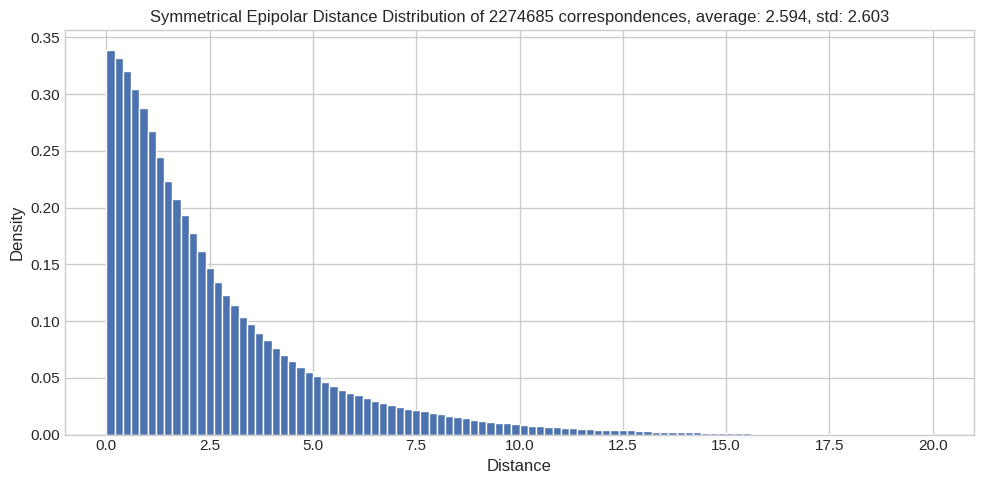

In [42]:
import kornia
from scipy.ndimage import map_coordinates

corr_points_i = torch.cat(corr_points_i_list, dim=0)
corr_points_j = torch.cat(corr_points_j_list, dim=0)
weight = torch.cat(scores_list, dim=0)

intrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
intrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
intrinsic_i[:, :3, :3] = intrinsic[frame_indexes_i]
intrinsic_j[:, :3, :3] = intrinsic[frame_indexes_j]
intrinsic_i[:, 3, 3] = 1.0
intrinsic_j[:, 3, 3] = 1.0

extrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
extrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
extrinsic_i[:, :3, :4] = extrinsic[frame_indexes_i]
extrinsic_j[:, :3, :4] = extrinsic[frame_indexes_j]
extrinsic_i[:, 3, 3] = 1.0
extrinsic_j[:, 3, 3] = 1.0

intrinsic_i_tensor = torch.FloatTensor(intrinsic_i).to(device)
intrinsic_j_tensor = torch.FloatTensor(intrinsic_j).to(device)
extrinsic_i_tensor = torch.FloatTensor(extrinsic_i).to(device)
extrinsic_j_tensor = torch.FloatTensor(extrinsic_j).to(device)

with torch.no_grad():
    corr_points_i_normalized = corr_points_i.to(images.device) / original_coords[frame_indexes_i][:, None, 2:4] * 2 - 1
    corr_points_j_normalized = corr_points_j.to(images.device) / original_coords[frame_indexes_j][:, None, 2:4] * 2 - 1

    P_i = intrinsic_i_tensor @ extrinsic_i_tensor
    P_j = intrinsic_j_tensor @ extrinsic_j_tensor
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i, corr_points_j, Fm, squared=False, eps=1e-08)
    err = err[weight > 1e-6] * weight[weight > 1e-6] / weight[weight > 1e-6].mean()
    # weights = err.clone()

# show the error distributionaq
plt.figure(figsize=(10, 5))
plt.hist(err.cpu().numpy(), bins=100, density=True, range=(0, 20))
plt.title(f"Symmetrical Epipolar Distance Distribution of {len(err)} correspondences, average: {err.mean().item():.3f}, std: {err.std().item():.3f}")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [43]:
save_dir = os.path.join(os.path.dirname(data_dir)+'_vggt', os.path.basename(data_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.save(os.path.join(save_dir, f'corr.npy'), {
    'corr_points_i_normalized': corr_points_i_normalized.cpu().numpy(),
    'corr_points_j_normalized': corr_points_j_normalized.cpu().numpy(),
    'corr_weights': weight.cpu().numpy(),
    'image_names_i': np.array(image_names_i),
    'image_names_j': np.array(image_names_j),
})

print(f"Point correspondences saved to {os.path.join(save_dir, f'corr.npy')}.")

Point correspondences saved to ../data/MipNeRF360_vggt/bonsai/corr.npy.


## 2. Optimize Pose

In [9]:
def make_K_cam_depth(log_focals, pps, trans, quats, min_focals, max_focals, imsizes):
    # make intrinsics
    focals = log_focals.exp().clip(min=min_focals, max=max_focals)
    K = torch.eye(4, dtype=focals.dtype, device=focals.device)[None].expand(len(trans), 4, 4).clone()
    K[:, 0, 0] = K[:, 1, 1] = focals
    K[:, 0:2, 2] = pps * imsizes
    if trans is None:
        return K

    w2cs = torch.eye(4, dtype=trans.dtype, device=trans.device)[None].expand(len(trans), 4, 4).clone()
    w2cs[:, :3, :3] = roma.unitquat_to_rotmat(F.normalize(quats, dim=1))
    w2cs[:, :3, 3] = trans

    return K, (w2cs, torch.linalg.inv(w2cs))

def cosine_schedule(alpha, lr_base, lr_end=0):
    lr = lr_end + (lr_base - lr_end) * (1 + np.cos(alpha * np.pi)) / 2
    return lr

def adjust_learning_rate_by_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr

def l1_loss(x, y):
    return torch.linalg.norm(x - y, dim=-1)

def gamma_loss(gamma, mul=1, offset=None, clip=np.inf):
    if offset is None:
        if gamma == 1:
            return l1_loss
        # d(x**p)/dx = 1 ==> p * x**(p-1) == 1 ==> x = (1/p)**(1/(p-1))
        offset = (1 / gamma)**(1 / (gamma - 1))

    def loss_func(x, y):
        return (mul * l1_loss(x, y).clip(max=clip) + offset) ** gamma - offset ** gamma
    return loss_func

In [10]:
shared_intrinsics = True

with torch.no_grad():
    imsizes = torch.tensor(images.shape[-2:]).float()
    diags = torch.norm(imsizes)
    min_focals = 0.25 * diags  # diag = 1.2~1.4*max(W,H) => beta >= 1/(2*1.2*tan(fov/2)) ~= 0.26
    max_focals = 10 * diags

    qvec = roma.rotmat_to_unitquat(torch.tensor(extrinsic[:, :3, :3]))
    tvec = torch.tensor(extrinsic[:, :3, 3])
    log_sizes = torch.zeros(len(qvec))

    pps = torch.tensor(intrinsic[:, :2, 2]) / imsizes[None, :2]  # default principal_point would be (0.5, 0.5)
    base_focals = torch.tensor((intrinsic[:, 0, 0] + intrinsic[:, 1, 1]) / 2)

    # intrinsics parameters
    if shared_intrinsics:
        # Optimize a single set of intrinsics for all cameras. Use averages as init.
        confs = depth_conf.mean(axis=(1, 2))
        weighting = torch.tensor(confs / confs.sum())
        pps = weighting @ pps
        pps = pps.view(1, -1).repeat(len(qvec), 1)
        focal_m = weighting @ base_focals
        log_focals = focal_m.view(1).log().repeat(len(qvec))
    else:
        log_focals = base_focals.log()
    
    depth_map_tensor = torch.tensor(depth_map)  # [B, H, W]
    depth_conf_tensor = torch.tensor(depth_conf)  # [B, H, W]

In [11]:
corr_path = os.path.join(os.path.dirname(data_dir)+'_vggt', os.path.basename(data_dir), 'corr.npy')
correspondence = np.load(corr_path, allow_pickle=True)
corr_points_i_normalized = correspondence.item()["corr_points_i_normalized"]
corr_points_j_normalized = correspondence.item()["corr_points_j_normalized"]
corr_weights = correspondence.item()["corr_weights"]  # filter outliers, < 7.5 pixels
image_names_i = correspondence.item()["image_names_i"]
image_names_j = correspondence.item()["image_names_j"]

hist, bin_edges = np.histogram(corr_weights, bins=100, range=(0, 20), density=True)
remapped_corr_weights = np.zeros_like(corr_weights, dtype=corr_weights.dtype)
for i in range(len(bin_edges) - 1):
    mask = (corr_weights >= bin_edges[i]) & (corr_weights < bin_edges[i + 1])
    if np.any(mask):
        remapped_corr_weights[mask] = (hist[i] * (bin_edges[i + 1] - bin_edges[i])) / (bin_edges[-1] - bin_edges[0])
corr_weights = remapped_corr_weights

outbound_mask_i = (corr_points_i_normalized[..., 0] < -1.0) | (corr_points_i_normalized[..., 0] > 1.0) | \
                    (corr_points_i_normalized[..., 1] < -1.0) | (corr_points_i_normalized[..., 1] > 1.0)
outbound_mask_j = (corr_points_j_normalized[..., 0] < -1.0) | (corr_points_j_normalized[..., 0] > 1.0) | \
                    (corr_points_j_normalized[..., 1] < -1.0) | (corr_points_j_normalized[..., 1] > 1.0)

corr_weights[outbound_mask_i | outbound_mask_j] = 0.0

with torch.no_grad():
    in_mask_i = np.isin(image_names_i, base_image_path_list)
    in_mask_j = np.isin(image_names_j, base_image_path_list)
    in_mask = in_mask_i & in_mask_j
    
    image_names_i = image_names_i[in_mask]
    image_names_j = image_names_j[in_mask]
    indexes_i = [base_image_path_list.index(img_name) for img_name in image_names_i]
    indexes_j = [base_image_path_list.index(img_name) for img_name in image_names_j]
    
    corr_points_i = torch.tensor(corr_points_i_normalized[in_mask])
    corr_points_j = torch.tensor(corr_points_j_normalized[in_mask])
    corr_weight_valid = torch.tensor(corr_weights[in_mask])

    depths_i = torch.zeros((corr_points_i.shape[0], corr_points_i.shape[1], 1), dtype=depth_map_tensor.dtype)
    depths_j = torch.zeros((corr_points_j.shape[0], corr_points_j.shape[1], 1), dtype=depth_map_tensor.dtype)

    for k, frame_idx in tqdm(enumerate(indexes_i)):
        depths_i[k] = F.grid_sample(
            depth_map_tensor[frame_idx].unsqueeze(0).permute(0, 3, 1, 2),
            corr_points_i[k][None, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(0, 2).permute(1, 0)

    for k, frame_idx in tqdm(enumerate(indexes_j)):
        depths_j[k] = F.grid_sample(
            depth_map_tensor[frame_idx].unsqueeze(0).permute(0, 3, 1, 2),
            corr_points_j[k][None, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(0, 2).permute(1, 0)
    

    corr_points_i[..., 0] = imsizes[..., 1] * (corr_points_i[..., 0] + 1) / 2
    corr_points_i[..., 1] = imsizes[..., 0] * (corr_points_i[..., 1] + 1) / 2
    corr_points_j[..., 0] = imsizes[..., 1] * (corr_points_j[..., 0] + 1) / 2
    corr_points_j[..., 1] = imsizes[..., 0] * (corr_points_j[..., 1] + 1) / 2

1193it [00:00, 13945.52it/s]
1193it [00:00, 10053.86it/s]


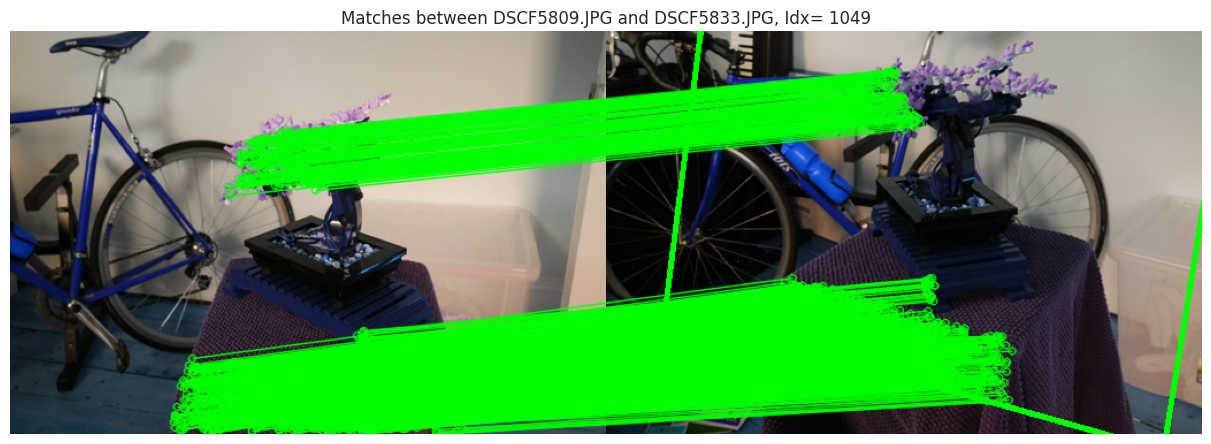

In [17]:
VISUALIZE_MATCHES = True
if VISUALIZE_MATCHES:
    k = random.randint(0, len(indexes_i) - 1)
    # k = 84
    idx_i = indexes_i[k]
    idx_j = indexes_j[k]
    im1 = images[idx_i:idx_i + 1]
    im2 = images[idx_j:idx_j + 1]

    canvas = warp_corners_and_draw_matches(corr_points_i[k][corr_weight_valid[k] > 0].cpu().numpy(), 
                                           corr_points_j[k][corr_weight_valid[k] > 0].cpu().numpy(), 
                                           im1, im2)
    plt.figure(figsize=(12,12))
    plt.imshow(canvas[..., ::-1])
    plt.title(f"Matches between {image_names_i[k]} and {image_names_j[k]}, Idx= {k}")
    plt.axis('off')
    plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


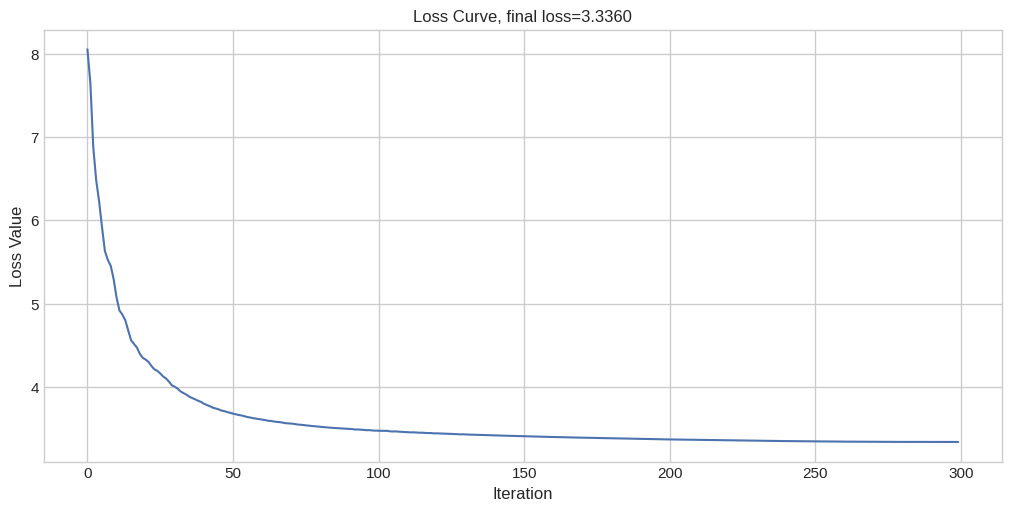

In [70]:
# first stage, only optimizes extrinsic_j_tensor and log_sizes
torch.cuda.empty_cache()

lr_base=0.0005
lr_end=0
niter=300
depth_batch_size = 16

depths_i = depths_i.to(device).squeeze(-1)
depths_j = depths_j.to(device).squeeze(-1) 

qvec = qvec.to(device)
tvec = tvec.to(device)
log_sizes = log_sizes.to(device)
min_focals = min_focals.to(device)
max_focals = max_focals.to(device)
imsizes = imsizes.to(device)
pps = pps.to(device)
log_focals = log_focals.to(device)

corr_points_i = corr_points_i.to(device)
corr_points_j = corr_points_j.to(device)
corr_weight_valid = corr_weight_valid.to(device)
corr_weight_valid /= corr_weight_valid.mean()  # normalize weights
corr_weight_valid = corr_weight_valid**2

params = [{
    "params": [
        qvec.requires_grad_(True), 
        tvec.requires_grad_(True), 
        log_sizes.requires_grad_(True),
    ],
    "name": ["qvec", "tvec", "log_sizes"]
}]

optimizer = torch.optim.Adam(params, lr=1, weight_decay=0, betas=(0.9, 0.9))

loss_list = []
for iter in tqdm(range(niter or 1)):
    K, (w2cam, cam2w) = make_K_cam_depth(log_focals, pps, tvec, qvec, min_focals, max_focals, imsizes)
    
    
    alpha = (iter / niter)
    lr = cosine_schedule(alpha, lr_base, lr_end)
    adjust_learning_rate_by_lr(optimizer, lr)
    optimizer.zero_grad()

    Ks_i = K[indexes_i]
    Ks_j = K[indexes_j]
    w2cam_i = w2cam[indexes_i]
    w2cam_j = w2cam[indexes_j]
    cam2w_i = cam2w[indexes_i]
    cam2w_j = cam2w[indexes_j]

    loss = 0.0

    sizes = log_sizes.exp()
    global_scaling = 1 / sizes.min()
    depths_i_scaled = depths_i * global_scaling * sizes[indexes_i][..., None]
    depths_j_scaled = depths_j * global_scaling * sizes[indexes_j][..., None]
    
    cam_coords_i = torch.stack([
        (corr_points_i[..., 0] - Ks_i[:, None, 0, 2]) / Ks_i[:, None, 0, 0],
        (corr_points_i[..., 1] - Ks_i[:, None, 1, 2]) / Ks_i[:, None, 1, 1],
        depths_i_scaled
    ], dim=-1)
    cam_coords_j = torch.stack([
        (corr_points_j[..., 0] - Ks_j[:, None, 0, 2]) / Ks_j[:, None, 0, 0],
        (corr_points_j[..., 1] - Ks_j[:, None, 1, 2]) / Ks_j[:, None, 1, 1],
        depths_j_scaled
    ], dim=-1)
    world_coords_i = (cam2w_i[:, :3, :3] @ cam_coords_i.permute(0, 2, 1)).permute(0, 2, 1) + cam2w_i[:, None, :3, 3]
    world_coords_j = (cam2w_j[:, :3, :3] @ cam_coords_j.permute(0, 2, 1)).permute(0, 2, 1) + cam2w_j[:, None, :3, 3]
    
    loss = ((world_coords_i - world_coords_j).abs() * corr_weight_valid[..., None]).mean() * 0.01

    P_i = Ks_i @ w2cam_i
    P_j = Ks_j @ w2cam_j
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i, corr_points_j, Fm, squared=False, eps=1e-08)
    # err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, :2], corr_points_j[:, :2], Fm, squared=False, eps=1e-08)
    loss = loss + (err * corr_weight_valid).mean() * 1.0
    
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title(f'Loss Curve, final loss={loss_list[-1]:.4f}')
plt.show()

In [71]:
# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(w2cam), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(w2cam[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(w2cam[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

/tmp/ipykernel_16671/418439452.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, :3, :3] = torch.tensor(w2cam[:, :3, :3], device=device)
/tmp/ipykernel_16671/418439452.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, 3, :3] = torch.tensor(w2cam[:, :3, 3], device=device)


    --  Umeyama Scale:  0.13293843407856856
    --  Umeyama Rotation: 
 [[ 0.44615594  0.64144203 -0.62409698]
 [-0.23017008  0.75613374  0.61260391]
 [ 0.86485066 -0.1296684   0.4849943 ]]
    --  Umeyama Translation: 
 [[ 0.03165154]
 [-0.29330948]
 [ 0.46943469]]
    --  Pair Rot   Error (Deg) of Vanilla:       2.21
    --  Pair Trans Error (Deg) of Vanilla:       2.82
    --  AUC at 30: 0.9015
